In [1]:
text='you say goodbye and i say hello.'

In [2]:
text=text.lower()
text=text.replace('.',' .')
text

'you say goodbye and i say hello .'

In [3]:
words=text.split()
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [4]:
word_to_id={}
id_to_word={}

for word in words:
    if word not in word_to_id:
        new_id=len(word_to_id)
        word_to_id[word]=new_id
        id_to_word[new_id]=word

In [5]:
print(word_to_id)
print(id_to_word)

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
# 단어목록을 단어ID목록으로 변환해보자.
import numpy as np

corpus=[word_to_id[w] for w in words]
corpus=np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [7]:
def preprocess(text):
    text=text.lower()
    text=text.replace('.',' .')
    words=text.split()

    word_to_id={}
    id_to_word={}
    for word in words:
        if word not in word_to_id:
            new_id=len(word_to_id)
            word_to_id[word]=new_id
            id_to_word[new_id]=word
    
    corpus=np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [8]:
text='you say goodbye and i say hello'
corpus, word_to_id, id_to_word=preprocess(text)

In [7]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
from common.util import preprocess

text='you say goodbye and i say hello'

corpus, word_to_id, id_to_word=preprocess(text)

print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello'}


In [8]:
C=np.array([
    [0,1,0,0,0,0,0],
    [1,0,1,0,1,1,0],
    [0,1,0,1,0,0,0],
    [0,0,1,0,1,0,0],
    [0,1,0,1,0,0,0],
    [0,1,0,0,0,0,1],
    [0,0,0,0,0,1,0]
])

In [ ]:
#동시발생 행렬

#you say goodbye and i say hello 
#corpus=[0,1,2,3,4,1,5,6]

def create_co_matrix(corpus,vocab_size,window_size=1):
    corpus_size=len(corpus)
    co_matrix=np.zeros((vocab_size,vocab_size),dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1,window_size+1):
            left_idx=idx-i
            right_idx=idx+i

            if left_idx>=0:
                left_word_id=corpus[left_idx]
                co_matrix[word_id, left_word_id]+=1

            if right_idx<corpus_size:
                right_word_id=corpus[right_idx]
                co_matrix[word_id, right_word_id]+=1

    return co_matrix



In [12]:
# 코사인 유사도

def similarity(x,y):
    nx=x/np.sqrt(np.sum(x**2))
    ny=y/np.sqrt(np.sum(y**2))

    return np.dot(nx,ny)

#이 코드에는 문제가 있다. 영벡터를 들고올 때 오류가 난다.

In [13]:
def similarity(x,y,eps=1e-8):           #분모에 아주 작은 값을 더해줘서 분모가 0이 되지 않도록 한다.
    nx=x/np.sqrt(np.sum(x**2)+eps)
    ny=y/np.sqrt(np.sum(y**2)+eps)

    return np.dot(nx,ny)

In [14]:
import sys,os
sys.path.append(os.pardir)

from common.util import preprocess, create_co_matrix, cos_similarity

text='you say goodbye and i say hello'

corpus,word_to_id,id_to_word=preprocess(text)
C=create_co_matrix(corpus,len(word_to_id))

C0=C[word_to_id['you']]
C1=C[word_to_id['i']]

print(cos_similarity(C0,C1))

0.7071067758832467


In [16]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 1) 검색어를 꺼낸다.
    if query not in word_to_id:
        print(f'{query}(을)를 찾을 수 없습니다.')
        return 
    
    print(f'\n[query] {query}')
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 2) 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # 3) 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():       #argsort()는 오름차순을 함. 근데 유사도를 내림차순으로 만들기 위해 -1을 곱한다.(참고로 argsort()는 인덱스들을 반환함)
        if id_to_word[i] == query:
            continue
        print(f' {id_to_word[i]}: {similarity[i]}')
        
        count +=1
        if count >= top:
            return

In [19]:
import sys,os
sys.path.append(os.pardir)
from common.util import preprocess, create_co_matrix, most_similar

text='you say goodbye and i say hello'
corpus, word_to_id, id_to_word=preprocess(text)
vocab_size=len(word_to_id)
C=create_co_matrix(corpus, vocab_size)

most_similar('you',word_to_id, id_to_word, C, top=5)


[query] you
 hello: 0.9999999900000001
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 say: 0.0
 and: 0.0


In [1]:
def ppmi(C,verbose=False,eps=1e-8):
    M=np.zeros_like(C,dtype=np.int32)
    N=np.sum(C)
    S=np.sum(C,axis=0)
    total=C.shape[0]*C.shape[1]
    cnt=0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi=np.log2(C[i,j]*N/(S[j]*S[i])+eps)
            M[i,j]=np.max(0,pmi)

        if verbose:
            cnt+=1
            if cnt%(total//100+1)==0:
                print('%.1f%% 완료'%(100*cnt/total))

    return M

In [19]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('Co-occurrence Matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

Co-occurrence Matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [20]:
from common.util import most_similar
most_similar('you', word_to_id, id_to_word, W, top=5)


[query] you
 goodbye: 0.40786147117614746
 i: 0.40786147117614746
 hello: 0.2763834297657013
 say: 0.0
 and: 0.0


SVD 에 의한 차원 감소를 보기 전에 고유값 분해에 관한 내용을 보면 이해에 도움이 될 것이다.

In [21]:
# count_method_small.py
%matplotlib inline
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

In [22]:
# 동시발생 행렬
print(C[0])

# ppmi 행렬
print(W[0])

# 밀집벡터 표현
print(U[0])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.226e-16]


In [23]:
# 밀집 벡터의 차원을 감소시키려면(ex: 2차원 벡터로 줄이려면)
print(U[0,:2])


[-3.409e-01 -1.110e-16]


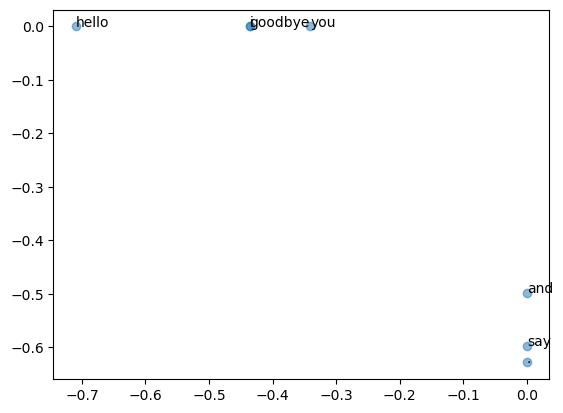

In [24]:
# 각 단어를 2차원 벡터로 표현 후 그래프로 그려보자.
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id,0],U[word_id,1]))     # U[word_id, 0]은 해당 단어의 첫 번째 특이벡터, U[word_id, 1]은 해당 단어의 두 번째 특이벡터

plt.scatter(U[:,0],U[:,1],alpha=0.5)        # U[:, 0]은 U 행렬의 첫 번째 열 (모든 단어의 첫 번째 특이벡터 값), 
                                            # U[:, 1]은 U 행렬의 두 번째 열 (모든 단어의 두 번째 특이벡터 값)
plt.show()

In [27]:
# show_ptb.py
import sys,os
sys.path.append(os.pardir)
from dataset import ptb

corpus, word_to_id, id_to_word=ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


In [28]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb

window_size=2
wordvec_size=100

corpus, word_to_id, id_to_word=ptb.load_data('train')
vocab_size=len(word_to_id)

print('동시발생 수 계산...')
C=create_co_matrix(corpus, vocab_size,window_size)
print('ppmi 계산...')
W=ppmi(C,verbose=True)

print('SVD 계산')
try:
    #truncated SVD(빠르다)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except:
    # SVD
    U, S, V = np.linalg.svd(W)

    
word_vecs = U[:, :wordvec_size]
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산...
ppmi 계산...


c:\git_experiment\RWL_Intern\dh_workspace\밑바닥부터 시작하는 딥러닝2\common\util.py:134: RuntimeWarning: overflow encountered in scalar multiply
  pmi = np.log2(C[i, j] * N / (S[i]*S[j]) + eps)
c:\git_experiment\RWL_Intern\dh_workspace\밑바닥부터 시작하는 딥러닝2\common\util.py:134: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i, j] * N / (S[i]*S[j]) + eps)


1.00 완료
2.00 완료
3.00 완료
4.00 완료
5.00 완료
6.00 완료
7.00 완료
8.00 완료
9.00 완료
10.00 완료
11.00 완료
12.00 완료
13.00 완료
14.00 완료
15.00 완료
16.00 완료
17.00 완료
18.00 완료
19.00 완료
20.00 완료
21.00 완료
22.00 완료
23.00 완료
24.00 완료
25.00 완료
26.00 완료
27.00 완료
28.00 완료
29.00 완료
30.00 완료
31.00 완료
32.00 완료
33.00 완료
34.00 완료
35.00 완료
36.00 완료
37.00 완료
38.00 완료
39.00 완료
40.00 완료
41.00 완료
42.00 완료
43.00 완료
44.00 완료
45.00 완료
46.00 완료
47.00 완료
48.00 완료
49.00 완료
50.00 완료
51.00 완료
52.00 완료
53.00 완료
54.00 완료
55.00 완료
56.00 완료
57.00 완료
58.00 완료
59.00 완료
60.00 완료
61.00 완료
62.00 완료
63.00 완료
64.00 완료
65.00 완료
66.00 완료
67.00 완료
68.00 완료
69.00 완료
70.00 완료
71.00 완료
72.00 완료
73.00 완료
74.00 완료
75.00 완료
76.00 완료
77.00 완료
78.00 완료
79.00 완료
80.00 완료
81.00 완료
82.00 완료
83.00 완료
84.00 완료
85.00 완료
86.00 완료
87.00 완료
88.00 완료
89.00 완료
90.00 완료
91.00 완료
92.00 완료
93.00 완료
94.00 완료
95.00 완료
96.00 완료
97.00 완료
98.00 완료
99.00 완료
100.00 완료
SVD 계산

[query] you
 i: 0.66563880443573
 we: 0.596425473690033
 anybody: 0.5776089429855347
 'll: 0.5501975